In [1]:
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 51.0 MB/s eta 0:00:00


In [9]:
!pip install networkx

Epoch 10/500, Loss: 0.0
Epoch 20/500, Loss: 0.0
Epoch 30/500, Loss: 0.0
Epoch 40/500, Loss: 0.0
Epoch 50/500, Loss: 0.0
Epoch 60/500, Loss: 0.0
Epoch 70/500, Loss: 0.0
Epoch 80/500, Loss: 0.0
Epoch 90/500, Loss: 0.0
Epoch 100/500, Loss: 0.0
Epoch 110/500, Loss: 0.0
Epoch 120/500, Loss: 0.0
Epoch 130/500, Loss: 0.0
Epoch 140/500, Loss: 0.0
Epoch 150/500, Loss: 0.0
Epoch 160/500, Loss: 0.0
Epoch 170/500, Loss: 0.0
Epoch 180/500, Loss: 0.0
Epoch 190/500, Loss: 0.0
Epoch 200/500, Loss: 0.0
Epoch 210/500, Loss: 0.0
Epoch 220/500, Loss: 0.0
Epoch 230/500, Loss: 0.0
Epoch 240/500, Loss: 0.0
Epoch 250/500, Loss: 0.0
Epoch 260/500, Loss: 0.0
Epoch 270/500, Loss: 0.0
Epoch 280/500, Loss: 0.0
Epoch 290/500, Loss: 0.0
Epoch 300/500, Loss: 0.0
Epoch 310/500, Loss: 0.0
Epoch 320/500, Loss: 0.0
Epoch 330/500, Loss: 0.0
Epoch 340/500, Loss: 0.0
Epoch 350/500, Loss: 0.0
Epoch 360/500, Loss: 0.0
Epoch 370/500, Loss: 0.0
Epoch 380/500, Loss: 0.0
Epoch 390/500, Loss: 0.0
Epoch 400/500, Loss: 0.0
Epoch 410

<ipython-input-50-d5d361efa604>:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', min_num_colors)


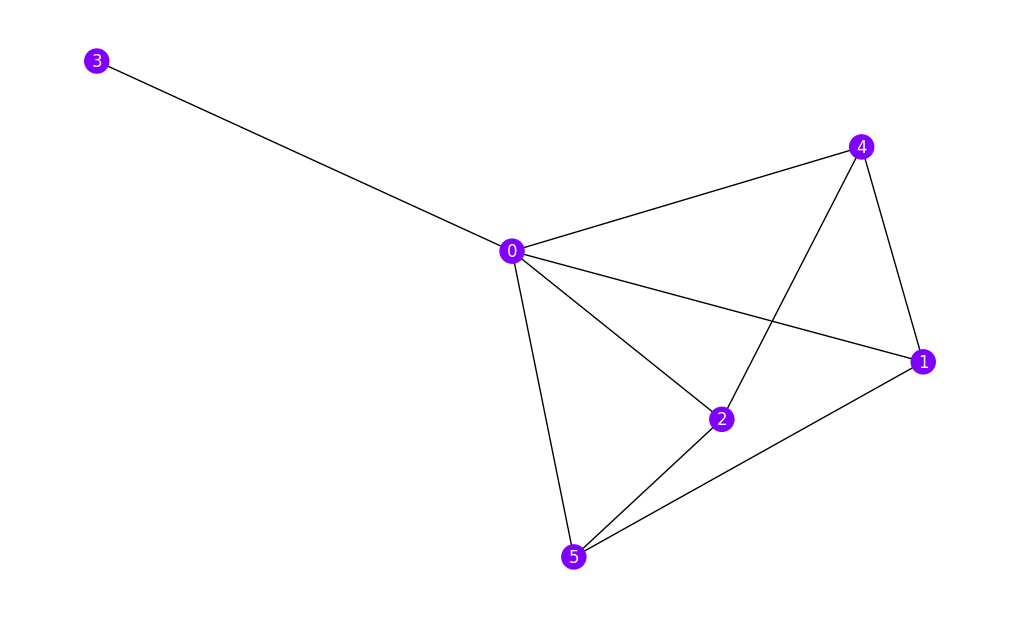

In [50]:
import dgl
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

class GraphColoringGNN(nn.Module):

    def __init__(self, num_nodes, embedding_dim, num_colors):
        super(GraphColoringGNN, self).__init__()

        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        self.gnn_layer1 = nn.GRUCell(embedding_dim, embedding_dim)
        self.gnn_layer2 = nn.GRUCell(embedding_dim, embedding_dim)
        self.fc = nn.Linear(embedding_dim, num_colors)

    def forward(self, graph):
        node_embeddings = self.embedding.weight
        node_embeddings = self.gnn_layer1(node_embeddings, node_embeddings)
        node_embeddings = self.gnn_layer2(node_embeddings, node_embeddings)
        logits = self.fc(node_embeddings)
        return logits

def train_model(model, graph, num_epochs, lr, num_colors):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        logits = model(graph)

        # Use logits directly as target labels
        target_labels = torch.argmax(logits, dim=1)

        loss = criterion(logits, target_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

    return model

# Generate a Barabási–Albert graph
num_nodes = 6  # Adjust the number of nodes as needed
ba_graph = nx.barabasi_albert_graph(num_nodes, 3)

# Convert the networkx graph to a DGL graph
dgl_graph = dgl.from_networkx(ba_graph)

embedding_dim = 16
num_epochs = 500
learning_rate = 0.01

# Generate random ground truth labels for the Barabási–Albert graph
ground_truth_labels = torch.randint(0, 2, (num_nodes,))

# Initialize the minimum number of colors to a large value
min_num_colors = float('inf')

# Iterate over different values of num_colors to find the minimum k
for num_colors in range(1, num_nodes + 1):
    # Create and train the GNN model
    model = GraphColoringGNN(num_nodes, embedding_dim, num_colors)
    trained_model = train_model(model, dgl_graph, num_epochs, learning_rate, num_colors)

    # Get the final color assignments from the trained model
    with torch.no_grad():
        final_logits = trained_model(dgl_graph)
        predicted_labels = torch.argmax(final_logits, dim=1)

    # Check if the current num_colors is a valid coloring
    unique_colors = len(set(predicted_labels.numpy()))
    print(f"Number of colors (k) for {num_colors} vertex: {unique_colors}")

    if unique_colors == num_colors:
        min_num_colors = min(min_num_colors, num_colors)

# Plot the graph with the final color assignments
pos = nx.spring_layout(ba_graph)
node_colors = predicted_labels.numpy()
cmap = plt.cm.get_cmap('rainbow', min_num_colors)
plt.figure(figsize=(10, 6))
nx.draw(ba_graph, pos, with_labels=True, node_color=node_colors, cmap=cmap, font_color='white')
#plt.title(f'Graph with {min_num_colors} Colors')
plt.show()
